In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.impute import MissingIndicator, SimpleImputer

from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

# plot_confusion_matrix is a handy visual tool, added in the latest version of scikit-learn
# if you are running an older version, comment out this line and just use confusion_matrix
from sklearn.metrics import plot_confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc
from sklearn.metrics import confusion_matrix

from sklearn.dummy import DummyClassifier
from sklearn import svm
from xgboost import XGBClassifier
#from imblearn.over_sampling import SMOTE
#from imblearn.pipeline import Pipeline
import folium

In [2]:
df_target = pd.read_csv('../data/water_table_labels.csv')

In [3]:
df_train = pd.read_csv('../data/water_table_training.csv')

# EDA

In [4]:
df_train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [5]:
target_list= df_target.status_group.tolist()

In [6]:
df_train['target'] = target_list

In [7]:
df_target.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [8]:
df_train.corr()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
id,1.000000,-0.005321,-0.004692,-0.001348,0.001718,-0.002629,-0.003028,-0.003044,-0.002813,-0.002082
amount_tsh,-0.005321,1.000000,0.076650,0.022134,-0.052670,0.002944,-0.026813,-0.023599,0.016288,0.067915
gps_height,-0.004692,0.076650,1.000000,0.149155,-0.035751,0.007237,-0.183521,-0.171233,0.135003,0.658727
longitude,-0.001348,0.022134,0.149155,1.000000,-0.425802,0.023873,0.034197,0.151398,0.086590,0.396732
latitude,0.001718,-0.052670,-0.035751,-0.425802,1.000000,0.006837,-0.221018,-0.201020,-0.022152,-0.245278
num_private,-0.002629,0.002944,0.007237,0.023873,0.006837,1.000000,-0.020377,-0.004478,0.003818,0.026056
region_code,-0.003028,-0.026813,-0.183521,0.034197,-0.221018,-0.020377,1.000000,0.678602,0.094088,0.031724
district_code,-0.003044,-0.023599,-0.171233,0.151398,-0.201020,-0.004478,0.678602,1.000000,0.061831,0.048315
population,-0.002813,0.016288,0.135003,0.086590,-0.022152,0.003818,0.094088,0.061831,1.000000,0.260910
construction_year,-0.002082,0.067915,0.658727,0.396732,-0.245278,0.026056,0.031724,0.048315,0.260910,1.000000


In [9]:
df_train.dtypes
#31 objs, 8 ints

id                         int64
amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_ty

In [10]:
df_train.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [11]:
df_train.isna().sum()
#scheme_management         3877
#scheme_name              28166
#permit                    3056
#public_meeting            3334
#subvillage                 371
#installer                 3655
#funder                    3635
#consider dropping scheme_name
#some kind of connection between funder and installer

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [12]:
df_target.status_group.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [13]:
numeric_columns = ["amount_tsh", "gps_height", "longitude", "latitude", "num_private", "region_code", 
                   "district_code", "population", "construction_year"]

# FSM Ternary

In [14]:
dummy_model = DummyClassifier(strategy="most_frequent")
#dummy model that will pick the largest class

In [15]:
numeric_df = df_train[numeric_columns]
X = numeric_df.drop("num_private", axis=1)
y = df_target["status_group"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2021)
#just using numeric columns as features

In [16]:
dummy_model.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [17]:
dummy_model.predict(X_train)

array(['functional', 'functional', 'functional', ..., 'functional',
       'functional', 'functional'], dtype='<U10')

In [18]:
cross_val_score(dummy_model, X_train, y_train, cv=3)
#score of about 54%
#terrible

array([0.54255892, 0.54249158, 0.54249158])

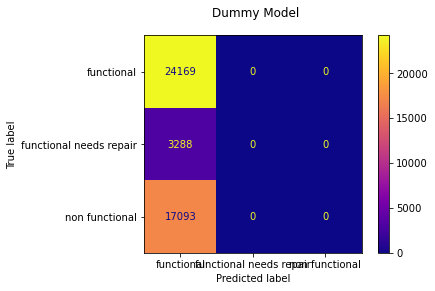

In [19]:
fig, ax = plt.subplots()

fig.suptitle("Dummy Model")

plot_confusion_matrix(dummy_model, X_train, y_train, ax=ax, cmap="plasma");

In [20]:
#next steps:

#use missing indicator:
#impute:
#scheme_management         3877
#scheme_name              28166
#permit                    3056
#public_meeting            3334
#subvillage                 371
#installer                 3655
#funder                    3635

#drop:
#wpt_name:name of the water point
#num_private: isn't given a description
#recorded_by: group that recorded data
#scheme_name: missing more than half its rows
# date recorded

#one hot encode all categorical values

#scale features

# work with either quantity or quantity group
#work with  quality group
#keep waterpoint_type
#keep source class and source 
#keep payment type
#keep management and management group
#extraction class and extraction type
#get rid of scheme name
#get rid of num_private
#drop subvillage
#drop date_recorded
#drop rows for na for funder and installer
#drop wpt_name
#df_clean = df_train.drop(['quantity'], , axis = 1)

# data cleaning round two

In [21]:
to_drop = ['date_recorded',  
'installer',
'wpt_name',  
'subvillage',  
'recorded_by',  
'scheme_name',  
'extraction_type_group',  
'payment',  
'water_quality',  
'quantity',  
'source_type',  
'waterpoint_type_group',
'num_private',
'region',
'ward',
'id',
'public_meeting'           
]
df_clean = df_train.drop(to_drop, axis = 1)
#drop id
#drop public meeting 

In [22]:
pd.set_option('display.max_columns', None)
df_clean.head(5)

,amount_tsh,funder,gps_height,longitude,latitude,basin,region_code,district_code,lga,population,scheme_management,permit,construction_year,extraction_type,extraction_type_class,management,management_group,payment_type,quality_group,quantity_group,source,source_class,waterpoint_type,target
0,6000.0,Roman,1390,34.938093,-9.856322,Lake Nyasa,11,5,Ludewa,109,VWC,False,1999,gravity,gravity,vwc,user-group,annually,good,enough,spring,groundwater,communal standpipe,functional
1,0.0,Grumeti,1399,34.698766,-2.147466,Lake Victoria,20,2,Serengeti,280,Other,True,2010,gravity,gravity,wug,user-group,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,functional
2,25.0,Lottery Club,686,37.460664,-3.821329,Pangani,21,4,Simanjiro,250,VWC,True,2009,gravity,gravity,vwc,user-group,per bucket,good,enough,dam,surface,communal standpipe multiple,functional
3,0.0,Unicef,263,38.486161,-11.155298,Ruvuma / Southern Coast,90,63,Nanyumbu,58,VWC,True,1986,submersible,submersible,vwc,user-group,never pay,good,dry,machine dbh,groundwater,communal standpipe multiple,non functional
4,0.0,Action In A,0,31.130847,-1.825359,Lake Victoria,18,1,Karagwe,0,NaN,True,0,gravity,gravity,other,other,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,functional


In [23]:
df_clean.shape
#(59400, 24)
#amount_tsh, gps_height, longitude, latitude, population

(59400, 24)

In [24]:
col_names = df_clean.columns
cat = [ 'funder', 'basin',
       'region_code', 'district_code', 'lga',
       'scheme_management', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_class', 'management', 'management_group',
       'payment_type', 'quality_group', 'quantity_group', 'source',
       'source_class', 'waterpoint_type']

In [25]:
df_clean.dropna(inplace=True)

In [26]:
df_clean.shape
#(51329, 24)

(51329, 24)

In [27]:
df_clean.isna().sum()

amount_tsh               0
funder                   0
gps_height               0
longitude                0
latitude                 0
basin                    0
region_code              0
district_code            0
lga                      0
population               0
scheme_management        0
permit                   0
construction_year        0
extraction_type          0
extraction_type_class    0
management               0
management_group         0
payment_type             0
quality_group            0
quantity_group           0
source                   0
source_class             0
waterpoint_type          0
target                   0
dtype: int64

# swtich from Ternerary to binary

In [28]:
df_clean.target.value_counts()
#functional                 32259
#non functional             22824
#functional needs repair     4317-


functional                 28076
non functional             19626
functional needs repair     3627
Name: target, dtype: int64

In [29]:
df_clean.head()

,amount_tsh,funder,gps_height,longitude,latitude,basin,region_code,district_code,lga,population,scheme_management,permit,construction_year,extraction_type,extraction_type_class,management,management_group,payment_type,quality_group,quantity_group,source,source_class,waterpoint_type,target
0,6000.0,Roman,1390,34.938093,-9.856322,Lake Nyasa,11,5,Ludewa,109,VWC,False,1999,gravity,gravity,vwc,user-group,annually,good,enough,spring,groundwater,communal standpipe,functional
1,0.0,Grumeti,1399,34.698766,-2.147466,Lake Victoria,20,2,Serengeti,280,Other,True,2010,gravity,gravity,wug,user-group,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,functional
2,25.0,Lottery Club,686,37.460664,-3.821329,Pangani,21,4,Simanjiro,250,VWC,True,2009,gravity,gravity,vwc,user-group,per bucket,good,enough,dam,surface,communal standpipe multiple,functional
3,0.0,Unicef,263,38.486161,-11.155298,Ruvuma / Southern Coast,90,63,Nanyumbu,58,VWC,True,1986,submersible,submersible,vwc,user-group,never pay,good,dry,machine dbh,groundwater,communal standpipe multiple,non functional
5,20.0,Mkinga Distric Coun,0,39.172796,-4.765587,Pangani,4,8,Mkinga,1,VWC,True,2009,submersible,submersible,vwc,user-group,per bucket,salty,enough,other,unknown,communal standpipe multiple,functional


In [30]:
target_list = df_clean.target.tolist()

In [31]:
t_list = ['non functional' if i=='functional needs repair' else i for i in target_list]

In [32]:
df_clean['bi_target'] = t_list

In [33]:
df_clean.head()

,amount_tsh,funder,gps_height,longitude,latitude,basin,region_code,district_code,lga,population,scheme_management,permit,construction_year,extraction_type,extraction_type_class,management,management_group,payment_type,quality_group,quantity_group,source,source_class,waterpoint_type,target,bi_target
0,6000.0,Roman,1390,34.938093,-9.856322,Lake Nyasa,11,5,Ludewa,109,VWC,False,1999,gravity,gravity,vwc,user-group,annually,good,enough,spring,groundwater,communal standpipe,functional,functional
1,0.0,Grumeti,1399,34.698766,-2.147466,Lake Victoria,20,2,Serengeti,280,Other,True,2010,gravity,gravity,wug,user-group,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,functional,functional
2,25.0,Lottery Club,686,37.460664,-3.821329,Pangani,21,4,Simanjiro,250,VWC,True,2009,gravity,gravity,vwc,user-group,per bucket,good,enough,dam,surface,communal standpipe multiple,functional,functional
3,0.0,Unicef,263,38.486161,-11.155298,Ruvuma / Southern Coast,90,63,Nanyumbu,58,VWC,True,1986,submersible,submersible,vwc,user-group,never pay,good,dry,machine dbh,groundwater,communal standpipe multiple,non functional,non functional
5,20.0,Mkinga Distric Coun,0,39.172796,-4.765587,Pangani,4,8,Mkinga,1,VWC,True,2009,submersible,submersible,vwc,user-group,per bucket,salty,enough,other,unknown,communal standpipe multiple,functional,functional


In [34]:
df_clean = df_clean.drop(['target'], axis = 1)

In [35]:
df_clean.head()

,amount_tsh,funder,gps_height,longitude,latitude,basin,region_code,district_code,lga,population,scheme_management,permit,construction_year,extraction_type,extraction_type_class,management,management_group,payment_type,quality_group,quantity_group,source,source_class,waterpoint_type,bi_target
0,6000.0,Roman,1390,34.938093,-9.856322,Lake Nyasa,11,5,Ludewa,109,VWC,False,1999,gravity,gravity,vwc,user-group,annually,good,enough,spring,groundwater,communal standpipe,functional
1,0.0,Grumeti,1399,34.698766,-2.147466,Lake Victoria,20,2,Serengeti,280,Other,True,2010,gravity,gravity,wug,user-group,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,functional
2,25.0,Lottery Club,686,37.460664,-3.821329,Pangani,21,4,Simanjiro,250,VWC,True,2009,gravity,gravity,vwc,user-group,per bucket,good,enough,dam,surface,communal standpipe multiple,functional
3,0.0,Unicef,263,38.486161,-11.155298,Ruvuma / Southern Coast,90,63,Nanyumbu,58,VWC,True,1986,submersible,submersible,vwc,user-group,never pay,good,dry,machine dbh,groundwater,communal standpipe multiple,non functional
5,20.0,Mkinga Distric Coun,0,39.172796,-4.765587,Pangani,4,8,Mkinga,1,VWC,True,2009,submersible,submersible,vwc,user-group,per bucket,salty,enough,other,unknown,communal standpipe multiple,functional


In [36]:
df_combo = df_clean[['region_code', 'scheme_management', 'quality_group', 
                    'quantity_group', 'source', 'extraction_type_class', 'waterpoint_type', 'bi_target']]
df_num = df_clean[['amount_tsh', 'construction_year', 'latitude', 'longitude']]
df_completed = df_num.join(df_combo, how='outer')
df_completed.shape
#(51329, 12)

(51329, 12)

# Binary EDA

In [37]:
df_clean.head()
df_basin_pop = df_clean[['basin', 'population', 'bi_target']]
#subset for just columns being used

In [38]:
df_pop_map = df_basin_pop.groupby(['basin']).sum()
df_pop_map.head()
#groupby to check the total population associated iwth each basin

,population
basin,
Internal,1066930
Lake Nyasa,294052
Lake Rukwa,394352
Lake Tanganyika,1674470
Lake Victoria,789684


Text(0.5, 1.0, 'Population Per Basin')

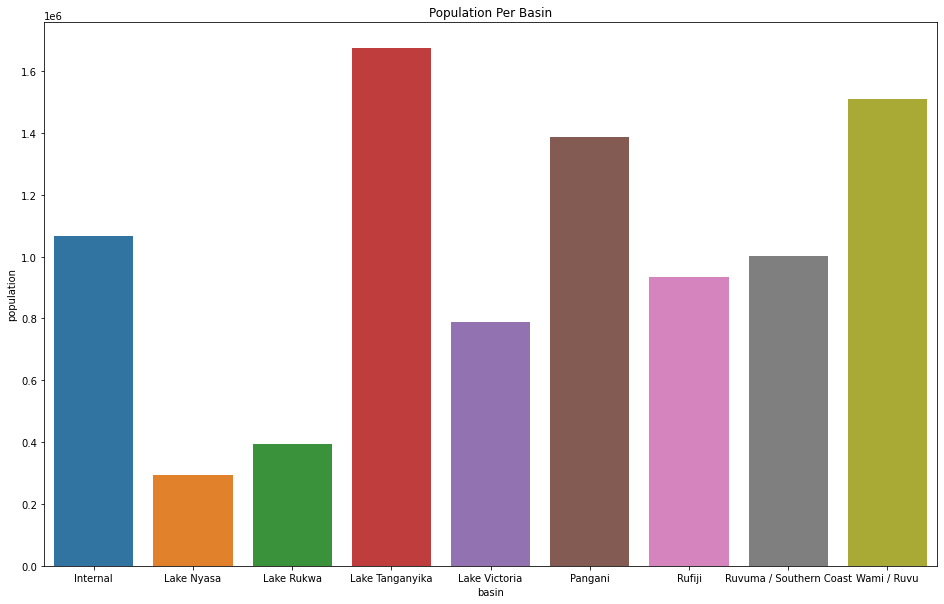

In [39]:
fig, ax = plt.subplots(figsize=(16,10))
sns.barplot(x=df_pop_map.index, y="population", data=df_pop_map, ax =ax).set_title('Population Per Basin')
#plot of each basin and its population

In [40]:
df_basin_target = df_basin_pop.drop('population', axis = 1)
#drop population from data fram

In [41]:
df_basin_target_map = df_basin_target.value_counts()
#check value_counts() for how many functional or non funcitonal water points each basin has
#df_basin_target.groupby([ 'basin']).sum()
df_basin_target_map

basin_name = ['Pangani', 'Lake Victoria', 'Lake Victoria', 'Rufiji', 'Internal', 'Pangani', 'Wami / Ruvu', 'Lake Tanganyika',
              'Wami / Ruvu', 'Lake Tanganyika', 'Internal', 'Lake Nyasa', 'Ruvuma / Southern Coast',
              'Rufiji', 'Ruvuma / Southern Coast', 'Lake Rukwa', 'Lake Nyasa', 'Lake Rukwa']

target_list = ['functional', 'non functional', 'functional', 'functional', 'functional', 'non functional', 'functional'
               , 'non functional', 'non functional', 'functional', 'non functional', 'functional', 'non functional', 
               'non functional', 'functional', 'non functional', 'non functional', 'functional']

count_list = [5160, 4280, 4211, 4033, 3802, 3400, 3116, 3058, 2815, 2792, 2528, 2480, 2462, 2005, 1487, 1440, 1265, 995]

dict = {'basin':basin_name, 'target': target_list, 'count': count_list}
df_b_t_c = pd.DataFrame(dict)
#use information from .value counts to constuct a new dataframe containing
#the number of funcitonal or non functional water points for each basin

In [42]:
df_b_t_c.head()

,basin,target,count
0,Pangani,functional,5160
1,Lake Victoria,non functional,4280
2,Lake Victoria,functional,4211
3,Rufiji,functional,4033
4,Internal,functional,3802


Text(0.5, 1.0, 'Functionaility of Waterpoints by Basin')

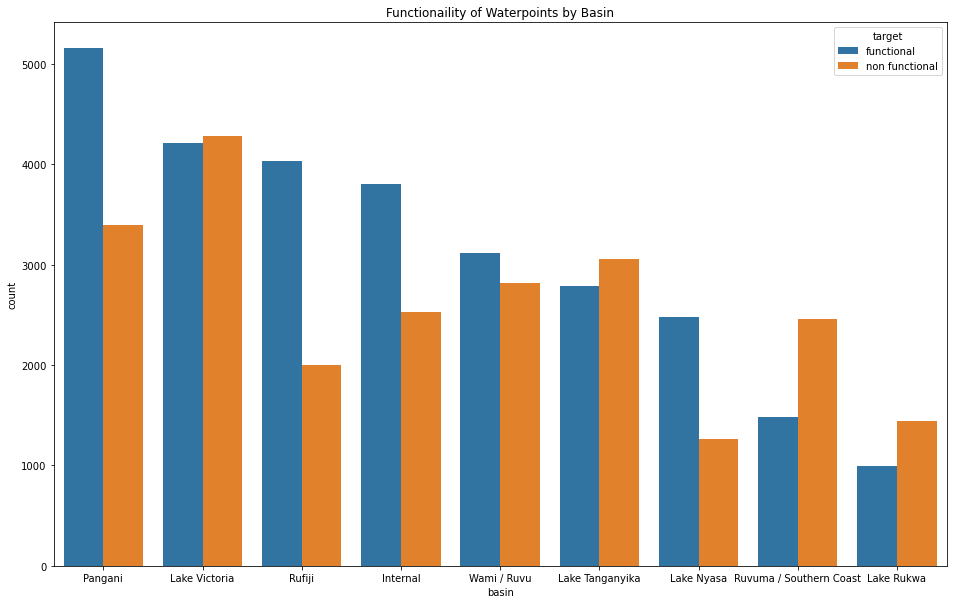

In [43]:
fig, ax = plt.subplots(figsize=(16,10))
sns.barplot(x="basin", y="count", hue="target", data=df_b_t_c, ax = ax).set_title('Functionaility of Waterpoints by Basin')
#plot of how many funcitonal and non functional water points each absin has

# Folium EDA

In [44]:
import folium

In [45]:
df_clean.basin.value_counts()
#cheack how many water points each basin has

Pangani                    8560
Lake Victoria              8491
Internal                   6330
Rufiji                     6038
Wami / Ruvu                5931
Lake Tanganyika            5850
Ruvuma / Southern Coast    3949
Lake Nyasa                 3745
Lake Rukwa                 2435
Name: basin, dtype: int64

In [46]:
df_clean.bi_target.value_counts()
#check target distribution

functional        28076
non functional    23253
Name: bi_target, dtype: int64

In [47]:
def namer(name):
    """takes in a name as a string and returns folium formatted name"""
    named = "<i>" + name +"</i>"
    return named

In [48]:
def basin_mapper():
    
    """Takes no argument and plots all 8 basins on folium map"""
    
    b_map = folium.Map(location=[-6.1630, 35.7516], zoom_start=6, tiles="Stamen Terrain")
    #plots initial space for general area, using tanzania's coordinates
    
    basins = ['Pangani', 'Lake Victoria', 'Lake Nyasa', 'Lake Rukwa', 'Lake Tanganyika',
              'Rufiji', 'Wami / Ruvu', 'Ruvuma / Southern Coast']
    
    long_lat = [[-5.436390, 38.978951], [-0.755775, 33.438354], [-11.6707, 34.6857], [-7.029620, 31.343060], 
                [-6.2556, 29.5108], [-7.773888, 39.363889], [-6.11667, 38.81667], [-10.474445, 34.8888]]
    
    for i in range(0, len(basins)):
        folium.Marker(long_lat[i], namer(basins[i]), icon=folium.Icon(color="purple"), tooltip=tooltip).add_to(b_map)
        #plots a purple marker for each basin
    
    return b_map

In [49]:
def basin_split(bname, df):
    """takes the name of a basin as a string and the cleaned df. 
    Returns pair as a list iwth basin name and basin coords.
    Returns coords_target as a nested list of waterpoint coords and their functionality tag
    """
    tooltip = "Click me!"
    basins = ['Pangani', 'Lake Victoria', 'Lake Nyasa', 'Lake Rukwa', 'Lake Tanganyika',
          'Rufiji', 'Wami / Ruvu', 'Ruvuma / Southern Coast']
    
    long_lat = [[-5.436390, 38.978951], [-0.755775, 33.438354], [-11.6707, 34.6857], [-7.029620, 31.343060], 
                [-6.2556, 29.5108], [-7.773888, 39.363889], [-6.11667, 38.81667], [-10.474445, 34.8888]]
    
    for name in range(0, len(basins)):
        if basins[name] == bname:
            pair = [bname, long_lat[name]]
            #gets the coordinates for the specifed basin only
    
    basin_df = df[['latitude', 'longitude', 'basin', 'bi_target']]

    df_basin = basin_df.loc[basin_df['basin'] == bname]
    
    target = df_basin.bi_target.head(200).tolist()
    long = df_basin.longitude.head(200).tolist()
    lat = df_basin.latitude.head(200).tolist()
    
    coords = [[la,lo] for la,lo in zip(lat, long)]
    #list comp to create lists of water point coordinates, [latitude, longitude]
    coords_target = [[t,c] for t,c in zip(target, coords)]
    #nested list containing [functionality, [latitude, longitude]]
    
    #print(coords[:5])

    return pair, coords_target

In [50]:
def map_build(basin):
    """takes in one parameter that consists of a list with a basin name and its coordinates
    and the coordinates of every water point connected to that basin. Creates a map with a
    marker for the basin and marlers for x amount water points. Builds maps ofindividual basins."""
    
    basin_name = basin[0][0]
    basin_coords = basin[0][1]
    coords = basin[1]
    
    b = folium.Map(location= basin_coords, zoom_start=8, tiles="Stamen Terrain")
    #plots initial space for general area, using specified basin's coordinates
    
    tooltip = "Click me!"
    
    for coord in coords:
        if coord[0] == 'functional':
            folium.Marker(coord[1], "<i>str(i)</i>", icon=folium.Icon(color="green"), tooltip=tooltip).add_to(b)
        else:
            folium.Marker(coord[1], "<i>str(i)</i>", icon=folium.Icon(color="red"), tooltip=tooltip).add_to(b)
            #plots green markers for functional basin and red markers for non functional basins
    
    folium.Marker(basin_coords, namer(basin_name), tooltip=tooltip, icon=folium.Icon(color="purple")).add_to(b)
    #plots purple ,markers for specified basin
        
    return b

In [51]:
basins = ['Pangani', 'Lake Victoria', 'Lake Nyasa', 'Lake Rukwa', 'Lake Tanganyika',
          'Rufiji', 'Wami / Ruvu', 'Ruvuma / Southern Coast']
# to use functioon map_build, a basin name must be picked and passed
#the return value should be saved in a variable and that variable
#must be run in its own cell

In [52]:
bname = basins[0]
Pangani  = map_build(basin_split(bname, df_clean))

In [53]:
bname_list = bname = basins[1]
Lake_Victoria  = map_build(basin_split(bname, df_clean))

In [54]:
bname_list = bname = basins[2]
Lake_Nyasa  = map_build(basin_split(bname, df_clean))

In [55]:
bname_list = bname = basins[3]
Lake_Rukwa = map_build(basin_split(bname, df_clean))

In [56]:
bname_list = bname = basins[4]
Lake_Tanganyika = map_build(basin_split(bname, df_clean))

In [57]:
bname_list = bname = basins[5]
Rufigi = map_build(basin_split(bname, df_clean))

In [58]:
bname_list = bname = basins[6]
wami_ruvu  = map_build(basin_split(bname, df_clean))

In [59]:
bname_list = bname = basins[7]
Ruvuma  = map_build(basin_split(bname, df_clean))

In [60]:
def Full_map(df):
    """Takes in the cleaned data frame and plots all eight basins and however many water points are specified"""
    
    basins = ['Pangani', 'Lake Victoria', 'Lake Nyasa', 'Lake Rukwa', 'Lake Tanganyika',
          'Rufiji', 'Wami / Ruvu', 'Ruvuma / Southern Coast']
    
    long_lat = [[-5.436390, 38.978951], [-0.755775, 33.438354], [-11.6707, 34.6857], [-7.029620, 31.343060], 
                [-6.2556, 29.5108], [-7.773888, 39.363889], [-6.11667, 38.81667], [-10.474445, 34.8888]]
    
    b = folium.Map(location= [-6.1630, 35.7516], zoom_start=6, tiles="Stamen Terrain")
    #plots initial space for general area, using tanzania's coordinates
    
    tooltip = "Click me!"
    
    for i in range(0, len(basins)):
        folium.Marker(long_lat[i], namer(basins[i]), tooltip=tooltip, icon=folium.Icon(color="purple")).add_to(b)
        #plots all 8 basins as purple markers

        
    basin_df = df[['latitude', 'longitude', 'basin', 'bi_target']]

    
    target = basin_df.bi_target.head(400).tolist()
    long = basin_df.longitude.head(400).tolist()
    lat = basin_df.latitude.head(400).tolist()
    #use of .head() to specify how many waterpoints to ma
    
            
    for k in range(0, len(target)):
        if target[i] == 'functional':
            #print('here')
            folium.Marker([lat[i],long[i]], "<i>str(i)</i>", icon=folium.Icon(color="green"), tooltip=tooltip).add_to(b)
            #print(trip[0])
        else:
            print('here')
            folium.Marker([lat[i],long[i]], "<i>str(i)</i>", icon=folium.Icon(color="red"), tooltip=tooltip).add_to(b)
            #plots green markers for functional basin and red markers for non functional basins
        
    return b

# Svitlana Data

In [61]:
df_clean

,amount_tsh,funder,gps_height,longitude,latitude,basin,region_code,district_code,lga,population,scheme_management,permit,construction_year,extraction_type,extraction_type_class,management,management_group,payment_type,quality_group,quantity_group,source,source_class,waterpoint_type,bi_target
0,6000.0,Roman,1390,34.938093,-9.856322,Lake Nyasa,11,5,Ludewa,109,VWC,False,1999,gravity,gravity,vwc,user-group,annually,good,enough,spring,groundwater,communal standpipe,functional
1,0.0,Grumeti,1399,34.698766,-2.147466,Lake Victoria,20,2,Serengeti,280,Other,True,2010,gravity,gravity,wug,user-group,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,functional
2,25.0,Lottery Club,686,37.460664,-3.821329,Pangani,21,4,Simanjiro,250,VWC,True,2009,gravity,gravity,vwc,user-group,per bucket,good,enough,dam,surface,communal standpipe multiple,functional
3,0.0,Unicef,263,38.486161,-11.155298,Ruvuma / Southern Coast,90,63,Nanyumbu,58,VWC,True,1986,submersible,submersible,vwc,user-group,never pay,good,dry,machine dbh,groundwater,communal standpipe multiple,non functional
5,20.0,Mkinga Distric Coun,0,39.172796,-4.765587,Pangani,4,8,Mkinga,1,VWC,True,2009,submersible,submersible,vwc,user-group,per bucket,salty,enough,other,unknown,communal standpipe multiple,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59394,500.0,World Bank,351,37.634053,-6.124830,Wami / Ruvu,5,6,Mvomero,89,VWC,True,2007,submersible,submersible,vwc,user-group,monthly,good,enough,machine dbh,groundwater,communal standpipe,non functional
59395,10.0,Germany Republi,1210,37.169807,-3.253847,Pangani,3,5,Hai,125,Water Board,True,1999,gravity,gravity,water board,user-group,per bucket,good,enough,spring,groundwater,communal standpipe,functional
59396,4700.0,Cefa-njombe,1212,35.249991,-9.070629,Rufiji,11,4,Njombe,56,VWC,True,1996,gravity,gravity,vwc,user-group,annually,good,enough,river,surface,communal standpipe,functional
59398,0.0,Malec,0,35.861315,-6.378573,Rufiji,1,4,Chamwino,0,VWC,True,0,nira/tanira,handpump,vwc,user-group,never pay,good,insufficient,shallow well,groundwater,hand pump,functional


In [62]:
final_columns_list = ['amount_tsh', 'longitude', 'latitude', 'construction_year', 'region_code', 'scheme_management', 'quality_group', 'quantity_group', 'source', 'extraction_type_class', 'waterpoint_type']

numericals = ['amount_tsh', 'longitude', 'latitude', 'construction_year']
categoricals = ['region_code', 'scheme_management', 'quality_group', 'quantity_group', 'source', 'extraction_type_class', 'waterpoint_type']

conditions = [df_clean['bi_target'] == 'functional', df_clean['bi_target'] == 'non functional']
choices = [0, 1]

df_clean['status_no'] = np.select(conditions, choices)
df_clean.drop('bi_target', axis = 1, inplace = True)

In [63]:
X = df_clean[final_columns_list]
y = df_clean['status_no']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, stratify = y, random_state = 42)

### Transformation on the Train Set

In [64]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        
        self.column_trans = None
    
    def fit(self, X_t, y_t = None):
        X_ = X_t.copy()
        column_transformer = ColumnTransformer(transformers = [('imputer', SimpleImputer(missing_values = 0.0, strategy = 'most_frequent'), ['construction_year']),                     
                                                      ('ohe', OneHotEncoder(sparse = False, handle_unknown = 'ignore'), categoricals)],
 
                                                      n_jobs = -1)
        column_transformer = column_transformer.fit(X_)
        self.column_trans = column_transformer
        return column_transformer
    
    def transform(self, X, y = None):

        X_ = self.column_trans.transform(X)
        return X_
        

In [65]:
logreg_pipe = Pipeline(steps =[('transform', CustomTransformer()),('scaler', StandardScaler()),('logreg', LogisticRegression())])
bernoulli_pipe = Pipeline(steps =[('transform', CustomTransformer()),('scaler', StandardScaler()),('bern', BernoulliNB())])
knn_pipe = Pipeline(steps =[('transform', CustomTransformer()),('scaler', StandardScaler()),('knn', KNeighborsClassifier())])
tree_pipe = Pipeline(steps =[('transform', CustomTransformer()),('scaler', StandardScaler()),('tree', DecisionTreeClassifier())])
forest_pipe = Pipeline(steps =[('transform', CustomTransformer()),('scaler', StandardScaler()),('forest', RandomForestClassifier())])
xgb_pipe = Pipeline(steps =[('transform', CustomTransformer()),('scaler', StandardScaler()),('xgb', XGBClassifier())])


### GridSearchCV parameters

In [66]:
logreg_params = {
   'logreg__C':[.1, .75],
   'logreg__max_iter':[500],
   'logreg__solver':['lbfgs', 'liblinear']
            }
                       
bernoulli_params = {'bern__alpha': list(np.linspace(.1, 1, 10))}

knn_params = {
    'knn__n_neighbors': [3, 7, 12], 
    'knn__weights':['uniform', 'distance'], 
    'knn__p':[1, 2, 3, 4]
             }

tree_params = {
    'tree__criterion':['gini', 'entropy'],  
    'tree__max_depth': [10, 25, 40, 55],
    'tree__min_samples_leaf':[1, 2, 3], 
    'tree__max_features': ['auto', 'sqrt']
              } 
forest_params = {
    'forest__n_estimators':[100, 125],
    'forest__criterion':['gini', 'entropy'],
    'forest__max_depth':[20, 40, None],
    'forest__min_samples_leaf':[1, 2, 3], 
    'forest__max_features': ['auto','sqrt', 'log2']
                }

xgb_params = {
        'xgb__eta':[.7, .9, 1.1],
        'xgb__max_depth': [6, 10, 15, 20],
        'xgb__learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
        'xgb__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'xgb__colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'xgb__colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'xgb__min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'xgb__gamma': [0, 0.25, 0.5, 1.0],
        'xgb__reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'xgb__n_estimators': [100, 120]
            }

### Logistic Regression

In [67]:
log_grid = GridSearchCV(estimator = logreg_pipe, param_grid = logreg_params, scoring = 'recall')
log_grid.fit(X_train, y_train)
log_grid.best_params_

{'logreg__C': 0.75, 'logreg__max_iter': 500, 'logreg__solver': 'lbfgs'}

### Bernoulli

In [68]:
bern_grid = GridSearchCV(estimator = bernoulli_pipe, param_grid = bernoulli_params, scoring = 'recall')
bern_grid.fit(X_train, y_train)
bern_grid.best_params_

{'bern__alpha': 0.1}

### RandomSearchCV on K Nearest Neighbors
Tossing this one due to computational weight.

In [69]:
#rs_knn = RandomizedSearchCV(estimator = knn_pipe,
#                        param_distributions = knn_params,
#                        n_iter = 10,                      
#                        random_state=42)

#rs_knn.fit(X_train, y_train)
#rs_knn.best_params_

### Decision Tree GridSearchCV

In [70]:
tree_grid = GridSearchCV(estimator = tree_pipe, param_grid = tree_params, scoring = 'recall')
tree_grid.fit(X_train, y_train)
tree_grid.best_params_

{'tree__criterion': 'gini',
 'tree__max_depth': 55,
 'tree__max_features': 'sqrt',
 'tree__min_samples_leaf': 1}

### RandomSearchCV on Random Forest

In [71]:
rs_forest = RandomizedSearchCV(estimator = forest_pipe,
                        param_distributions = forest_params,
                        n_iter = 10,                      
                        random_state=42)

rs_forest.fit(X_train, y_train)
rs_forest.best_params_

{'forest__n_estimators': 125,
 'forest__min_samples_leaf': 2,
 'forest__max_features': 'sqrt',
 'forest__max_depth': None,
 'forest__criterion': 'gini'}

### RandomSearchCV on XGB
Gridsearch is very computationally heavy so RandomSearch had to be used to reduce computation - still very heavy.

In [72]:
rs = RandomizedSearchCV(estimator = xgb_pipe,
                        param_distributions = xgb_params,
                        n_iter = 10,                      
                        random_state=42, return_train_score = True)

rs.fit(X_train, y_train)
rs.best_params_, rs.best_score_, rs.__dict__

({'xgb__subsample': 0.9,
  'xgb__reg_lambda': 1.0,
  'xgb__n_estimators': 120,
  'xgb__min_child_weight': 1.0,
  'xgb__max_depth': 15,
  'xgb__learning_rate': 0.1,
  'xgb__gamma': 1.0,
  'xgb__eta': 0.9,
  'xgb__colsample_bytree': 0.9,
  'xgb__colsample_bylevel': 0.5},
 0.7911744499486368,
 {'param_distributions': {'xgb__eta': [0.7, 0.9, 1.1],
   'xgb__max_depth': [6, 10, 15, 20],
   'xgb__learning_rate': [0.001, 0.01, 0.1, 0.2, 0, 3],
   'xgb__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
   'xgb__colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
   'xgb__colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
   'xgb__min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
   'xgb__gamma': [0, 0.25, 0.5, 1.0],
   'xgb__reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
   'xgb__n_estimators': [100, 120]},
  'n_iter': 10,
  'random_state': 42,
  'scoring': None,
  'estimator': Pipeline(steps=[('transform', CustomTransformer()),
                  ('scaler', StandardScaler()),
          

# Vanilla Models

## Model 1 - Logistic Regression

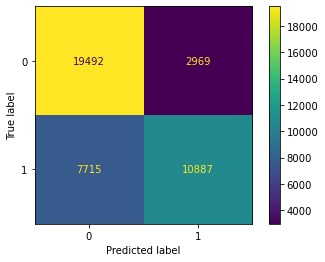

In [73]:
logreg_pipe.fit(X_train, y_train)
plot_confusion_matrix(logreg_pipe, X_train, y_train);

In [74]:
print("Accuracy Scores:", cross_val_score(logreg_pipe, X_train, y_train))
print("Mean Accuracy:", cross_val_score(logreg_pipe, X_train, y_train).mean())
"Recall Scores:", cross_validate(logreg_pipe, X_train, y_train, return_train_score= True, scoring = 'recall')

Accuracy Scores: [0.73882869 0.74211616 0.73773286 0.73514369 0.74171943]
Mean Accuracy: 0.7391081666413524


('Recall Scores:',
 {'fit_time': array([0.72007561, 1.04125547, 0.72558141, 0.7315526 , 0.75648642]),
  'score_time': array([0.08777213, 0.10372066, 0.08577061, 0.08078456, 0.08377624]),
  'test_score': array([0.58198925, 0.58989519, 0.58452029, 0.57043011, 0.58844086]),
  'train_score': array([0.58607714, 0.58147974, 0.58571333, 0.58721946, 0.58533799])})

## Model 2 - K Nearest Neighbors

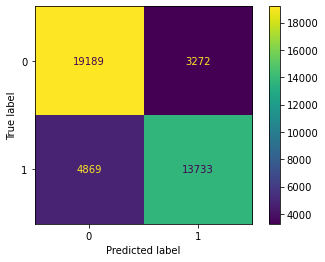

In [75]:
knn_pipe.fit(X_train, y_train)
plot_confusion_matrix(knn_pipe, X_train, y_train);

In [76]:
#print("Accuracy Scores:", cross_val_score(knn_pipe, X_train, y_train))
#"Recall Scores:", cross_validate(knn_pipe, X_train, y_train, return_train_score= True, scoring = 'recall')
#do not uncomment unless you're comfortable with waiting a really long time

## Model 3 - Decision Tree Classifier

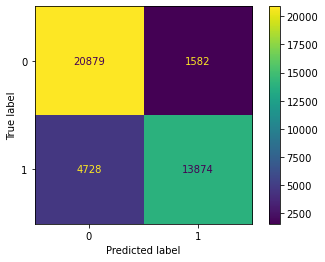

In [77]:
tree_pipe.fit(X_train, y_train)
plot_confusion_matrix(tree_pipe, X_train, y_train);

In [78]:
print("Accuracy Scores:", cross_val_score(tree_pipe, X_train, y_train))
print("Mean Accuracy:", cross_val_score(tree_pipe, X_train, y_train).mean())
"Recall Scores:", cross_validate(tree_pipe, X_train, y_train, return_train_score= True, scoring = 'recall')

Accuracy Scores: [0.77620845 0.78728845 0.77779131 0.7793473  0.77374574]
Mean Accuracy: 0.778584003868269


('Recall Scores:',
 {'fit_time': array([0.74973607, 0.72038317, 0.7392087 , 0.72783375, 0.74048114]),
  'score_time': array([0.06576443, 0.05129552, 0.05380535, 0.05109453, 0.0548532 ]),
  'test_score': array([0.65672043, 0.68180597, 0.66702499, 0.66532258, 0.6655914 ]),
  'train_score': array([0.74620347, 0.74779921, 0.74490962, 0.74801774, 0.74895847])})

## Model 4 - XGB Classifier

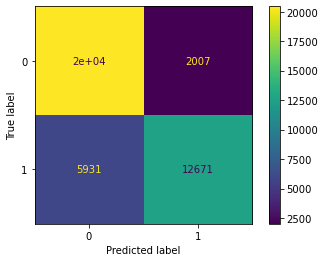

In [79]:
xgb_pipe.fit(X_train, y_train)
plot_confusion_matrix(xgb_pipe, X_train, y_train);

In [80]:
print("Accuracy Scores:", cross_val_score(xgb_pipe, X_train, y_train))
print("Mean Accuracy:", cross_val_score(xgb_pipe, X_train, y_train).mean())
"Recall Scores:", cross_validate(xgb_pipe, X_train, y_train, return_train_score= True, scoring = 'recall')

Accuracy Scores: [0.78144405 0.79763789 0.7850968  0.78190453 0.78531417]
Mean Accuracy: 0.7862794890710905


('Recall Scores:',
 {'fit_time': array([4.21973109, 4.91558361, 4.22348309, 4.14855385, 4.28275061]),
  'score_time': array([0.18094516, 0.1577518 , 0.14675093, 0.14238262, 0.1509378 ]),
  'test_score': array([0.65456989, 0.6855684 , 0.6640688 , 0.65806452, 0.65349462]),
  'train_score': array([0.68841554, 0.68973859, 0.6886634 , 0.69231286, 0.68062088])})

## Model 5 - Random Forest Classifier

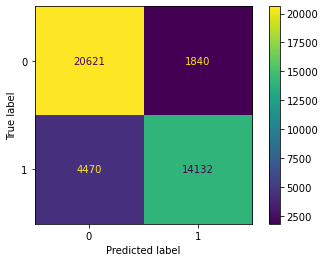

In [81]:
forest_pipe.fit(X_train, y_train)
plot_confusion_matrix(forest_pipe, X_train, y_train);

In [82]:
print("Accuracy Scores:", cross_val_score(forest_pipe, X_train, y_train))
print("Mean Accuracy:", cross_val_score(forest_pipe, X_train, y_train).mean())
"Recall Scores:", cross_validate(forest_pipe, X_train, y_train, return_train_score= True, scoring = 'recall')

Accuracy Scores: [0.78387922 0.79118471 0.78448801 0.7851924  0.77898198]
Mean Accuracy: 0.7848670436761982


('Recall Scores:',
 {'fit_time': array([4.63186193, 4.61822271, 5.35645223, 4.83857226, 4.58848763]),
  'score_time': array([0.32871294, 0.27826548, 0.26927948, 0.2659626 , 0.26732349]),
  'test_score': array([0.68010753, 0.7041118 , 0.68852459, 0.68333333, 0.69489247]),
  'train_score': array([0.76293509, 0.76433035, 0.76285196, 0.76367424, 0.77066255])})

# Tuned Models

## Tuned Model 1 - Decision Tree

In [83]:
tree_pipe_tuned = Pipeline(steps =[('transform', CustomTransformer()),('scaler', StandardScaler()), 
                                   ('tree', DecisionTreeClassifier(criterion = 'entropy',
                                                                   max_depth = 30,
                                                                   max_features = 'sqrt'))])

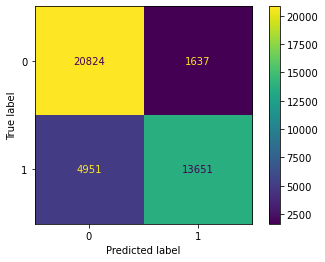

In [84]:
tree_pipe_tuned.fit(X_train, y_train)
plot_confusion_matrix(tree_pipe_tuned, X_train, y_train);

In [85]:
print("Accuracy Scores:", cross_val_score(tree_pipe_tuned, X_train, y_train))
print("Mean Accuracy:", cross_val_score(tree_pipe_tuned, X_train, y_train).mean())
"Recall Scores:", cross_validate(tree_pipe_tuned, X_train, y_train, return_train_score= True, scoring = 'recall')

Accuracy Scores: [0.77633021 0.7850968  0.77815658 0.7761812  0.77252801]
Mean Accuracy: 0.7733481319251452


('Recall Scores:',
 {'fit_time': array([0.4447825 , 0.44979978, 0.45094228, 0.47176504, 0.44281888]),
  'score_time': array([0.06581402, 0.05285668, 0.05289459, 0.05289507, 0.05884123]),
  'test_score': array([0.6188172 , 0.67858103, 0.64740661, 0.64166667, 0.65456989]),
  'train_score': array([0.68250235, 0.72300249, 0.70653854, 0.7145545 , 0.72268512])})

## Tuned Model 2 - XGBoost Classifier

In [86]:
xgb_pipe_tuned = Pipeline(steps =[('transform', CustomTransformer()),('scaler', StandardScaler()), 
                                  ('xgb', XGBClassifier(subsample=0.9,
                                                        reg_lambda=1.0,
                                                        n_estimators=150,
                                                        min_child_weight=1.0,
                                                        max_depth=40,
                                                        learning_rate=0.2,
                                                        gamma=1.0,
                                                        eta=0.9,
                                                        colsample_bytree=0.9,
                                                        colsample_bylevel=0.5))])

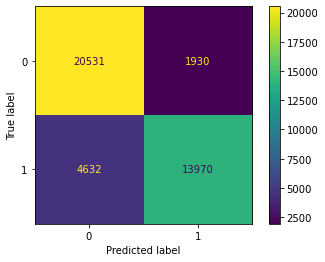

In [87]:
xgb_pipe_tuned.fit(X_train, y_train)
plot_confusion_matrix(xgb_pipe_tuned, X_train, y_train);

The recall calculations below take a little while, but they do work.  

In [88]:
print("Accuracy Scores:", cross_val_score(xgb_pipe_tuned, X_train, y_train))
print("Mean Accuracy:", cross_val_score(xgb_pipe_tuned, X_train, y_train).mean())
"Recall Scores:", cross_validate(xgb_pipe_tuned, X_train, y_train, return_train_score= True, scoring = 'recall')

Accuracy Scores: [0.78607086 0.79483745 0.78789724 0.78543595 0.78628836]
Mean Accuracy: 0.7881059716134395


('Recall Scores:',
 {'fit_time': array([21.32097054, 21.89784694, 21.44483018, 21.22076559, 20.98566413]),
  'score_time': array([0.22723961, 0.17653346, 0.20147848, 0.22221041, 0.19699574]),
  'test_score': array([0.68360215, 0.70357431, 0.69174953, 0.68682796, 0.69784946]),
  'train_score': array([0.75493885, 0.75337679, 0.75162959, 0.75258702, 0.75655154])})

Example result:

Accuracy Scores: [0.78667965 0.79374163 0.78570559 0.78592304 0.78677545]  
Mean Accuracy: 0.7877650724093515  
('Recall Scores:',  
 {'fit_time': array([21.27556515, 20.48738503, 20.44357967, 19.84486055, 19.39542603]),  
  'score_time': array([0.21004176, 0.20481229, 0.1889286 , 0.17752552, 0.20445323]),  
  'test_score': array([0.67903226, 0.70357431, 0.68691212, 0.68494624, 0.6983871 ]),  
  'train_score': array([0.74828652, 0.749412  , 0.74826961, 0.7485553 , 0.75251982])})  

## Tuned Model 3 - Random Forest Classifier

Although the search suggested that using gini as a criterion may be a stronger choice, the model seemed to perform better using entropy and with a set maximum depth.

In [89]:
forest_pipe_tuned = Pipeline(steps =[('transform', CustomTransformer()),('scaler', StandardScaler()),
                                     ('forest', RandomForestClassifier(n_estimators=200,
                                                                       max_features='sqrt',
                                                                       max_depth=45,
                                                                       criterion='entropy'))])

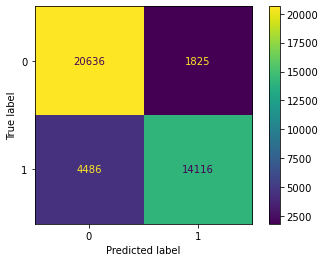

In [90]:
forest_pipe_tuned.fit(X_train, y_train)
plot_confusion_matrix(forest_pipe_tuned, X_train, y_train);

In [91]:
print("Accuracy Scores:", cross_val_score(forest_pipe_tuned, X_train, y_train))
print("Mean Accuracy:", cross_val_score(forest_pipe_tuned, X_train, y_train).mean())
"Recall Scores:", cross_validate(forest_pipe_tuned, X_train, y_train, return_train_score= True, scoring = 'recall')

Accuracy Scores: [0.78339218 0.79045416 0.78667965 0.78421822 0.77776425]
Mean Accuracy: 0.7845504605252895


('Recall Scores:',
 {'fit_time': array([ 9.13115263,  8.98556137,  9.11418939,  9.29675937, 10.10999084]),
  'score_time': array([0.48967695, 0.49821949, 0.4859097 , 0.51490927, 0.4837122 ]),
  'test_score': array([0.67956989, 0.70142435, 0.68744961, 0.68333333, 0.69435484]),
  'train_score': array([0.76246472, 0.76224716, 0.76036557, 0.76246472, 0.76884827])})

# Test Set

### XGBoost Classifier predictions on the test set

In [92]:
xgb_pipe_tuned.fit(X_train, y_train)

xgb_train_preds = xgb_pipe_tuned.predict(X_train)
xgb_test_preds = xgb_pipe_tuned.predict(X_test)

xgb_accuracy = accuracy_score(y_test, xgb_test_preds)
xgb_precision = precision_score(y_test, xgb_test_preds)
xgb_recall = recall_score(y_test, xgb_test_preds)

xgb_y_probas = xgb_pipe_tuned.predict_proba(X_test)[:,1]
xgb_tpr, xgb_fpr, xgb_thresholds = roc_curve(y_test, xgb_y_probas)
xgb_auc = auc(xgb_tpr, xgb_fpr)


print("XGBoost Classifier Stats:")
print("Test Accuracy: ", xgb_accuracy)
print("Test Precision: ", xgb_precision)
print("Test Recall: ", xgb_recall)

XGBoost Classifier Stats:
Test Accuracy:  0.7919345412039743
Test Precision:  0.8187579214195184
Test Recall:  0.6944743066007311


### Random Forest Classifier predictions on the test set

In [93]:
forest_pipe_tuned.fit(X_train, y_train)

forest_train_preds = forest_pipe_tuned.predict(X_train)
forest_test_preds = forest_pipe_tuned.predict(X_test)

forest_accuracy = accuracy_score(y_test, forest_test_preds)
forest_precision = precision_score(y_test, forest_test_preds)
forest_recall = recall_score(y_test, forest_test_preds)

forest_y_probas = forest_pipe_tuned.predict_proba(X_test)[:,1]
forest_tpr, forest_fpr, forest_thresholds = roc_curve(y_test, forest_y_probas)
forest_auc = auc(forest_tpr, forest_fpr)

print("Random Forest Classifier Stats:")
print("Test Accuracy: ", forest_accuracy)
print("Test Precision: ", forest_precision)
print("Test Recall: ", forest_recall)

Random Forest Classifier Stats:
Test Accuracy:  0.7917397233586596
Test Precision:  0.8161006289308176
Test Recall:  0.6974844119544185


## Tuned Model ROC Curves against each other on Test set

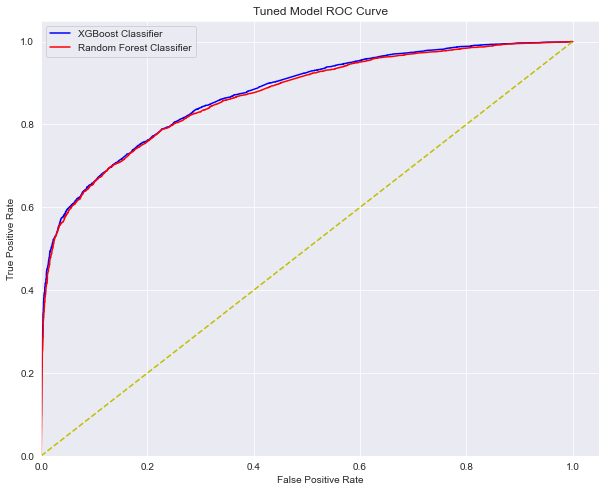

In [94]:
sns.set_style('darkgrid')
plt.figure(figsize=(10, 8))

plt.plot(xgb_tpr, xgb_fpr, color = 'b', label = 'XGBoost Classifier')
plt.plot(forest_tpr, forest_fpr, color = 'r', label = 'Random Forest Classifier')
plt.plot([0, 1], [0, 1], color = 'y', linestyle = '--')

plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Tuned Model ROC Curve')
plt.legend()
plt.show()